# Collaboration and Competition

---


## Introduction

Install a few packages, this line will take a few minutes to run!

In [1]:
%%time
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.
CPU times: user 1.05 s, sys: 126 ms, total: 1.18 s
Wall time: 1min 2s


### Get environment ready

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import deque

In [3]:
def initialize_env(unity_file):
    # Initialize the environment
    env = UnityEnvironment(file_name=unity_file)

    # Get default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    # Get state and action spaces
    env_info = env.reset(train_mode=True)[brain_name]
    state_size = env_info.vector_observations.shape[1]
    action_size = brain.vector_action_space_size
    n_agents = len(env_info.agents)
    
    print('State size: ', state_size)
    print('Action size: ', action_size)
    print('Number of agents: ', n_agents)
    
    return env, brain_name, brain, state_size, action_size, n_agents

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
env, brain_name, brain, state_size, action_size, n_agents = \
    initialize_env("/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


State size:  24
Action size:  2
Number of agents:  2


In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -7.38993645 -1.5        -0.          0.
  6.83172083  5.99607611 -0.          0.        ]


### Take Random Actions in the Environment

We use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [7]:
for i in range(3):                                         # play game for 3 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291


## Submission

### Algorithm

#### Policy-Based Methods

Value-based methods can only deal with comparably small state spaces.
A table with values of states and actions is filled through the agent's interaction with the environment.
Thereby the optimal value function $q_*$ helps to find the optimal policy $\pi_*$.
For bigger (also: continuous) state spaces deep neural networks are used to learn the optimal action-value network.
A well-known algorithm is Deep Q-Learning (DQN).

Policy-based methods, in contrast to that, try to estimate the optimal policy without worrying about the optimal value function.
Methods such as Hill Climbing, Gradient Ascend or Stochastic Policy Search can be used for Policy Function Approximation. The so called Cross-Entropy Method and Evolution Strategies are further algorithms in this field.

Policy-Based methods are helpful, since they
 1. are simpler than value-based methods,
 2. are able to learn true stochastic policies and
 3. are able to deal with continuous action spaces.

#### Actor-Critic Methods

The general idea of actor-critic methods is to use value-based methods to further reduce the variance of policy-based methods.
One uses two function approximators (typically neural networks) to learn a policy (the Actor) and a value function (the Critic); the actor is learning to act, whereas the critic is learning to estimate situations and actions.
This combination typically results in more stable learning than value-based agents alone, but also fewer samples are necessary than for policy-based agents alone.

A basic Actor-Critic agent works as follows:
 1. Actor: Observe state $s$ of the environment
 1. Actor: Calculate distribution of action probabilities $\pi(a \mid s; \theta_{\pi})$, select action and execute
 1. Actor: Observe experience tuple of state, action, reward and next state: $o=(s, a, r, s')$
 1. Critic: Use the tuple $o$ for TD-estimate, to train critic: $r + \gamma V(s'; \theta_{V})$
 1. Critic: Calculate the advantage $A(s, a) = r + \gamma V(s'; \theta_{V}) - V(s; \theta_{V}) $
 1. Actor: Train the actor using the advantage

Common algorithms are
 - A3C (Asynchronous Advantage Actor-Critic)
 - A2C (Advantage Actor-Critic)
 - Generalized Advantage Estimation
 - DDPG (Deep Deterministic Policy Gradient)

#### Deep Deterministic Policy Gradient

DDPG has been introduced in Lillicrap et al., 2016.
It is being used in the implementation in the following.

DDPG combines the actor-critic approach with Deep Q-Learning.
It can be seen as a kind of approximate DQN instead of an actual actor-critic.
The actor provides the current policy, mapping states to continuous deterministic actions.
The critic is used to calculate action values.
DDPG is using a replay buffer (like DQN), and target networks.
This means, there are 2 copies of the network weights for each network (regular+target for actor, regular+target for critic), where the targets are updated using a soft update strategy.
The target network is used for prediction to stabilize training, whereas the regular network is the one that is being trained.

Process Noise is added in order to handle exploration (Ornstein-Uhlenbeck noise).

### Implementation

> The following solution is based on the code provided in [Udacity ddpg-bipedal](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-bipedal/DDPG.ipynb). In particular, it uses the files [model.py](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-bipedal/model.py) and [ddpg_agent/py](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-bipedal/ddpg_agent.py), as well as the code provided in the training loop `ddpg()`.
The code is also heavily taking advantage of our submission of the second project, [see here](https://github.com/toebgen/deep-reinforcement-learning/blob/master/p2_continuous-control/Report.ipynb).

In [9]:
import datetime
def ddpg(env, brain_name, agent, n_agents,
         n_episodes=2000, t_max=2000):
    
    print('Starting ddpg()...')
    scores = []
    scores_deque = deque(maxlen=100)
    best_score = -np.Inf
    
    for i_episode in range(1, n_episodes+1):
        t_start = datetime.datetime.now()
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations
        agent.reset()
        score = np.zeros(n_agents)
        
        # for t in range(t_max):
        t = 0
        while True:
            # print('\rEpisode {}/{}, t: {}/{}'
            #      .format(i_episode, n_episodes, t, t_max), end="")
            action = agent.act(state)
            
            env_info = env.step(action)[brain_name]     # send all actions to the environment
            next_state = env_info.vector_observations   # get next state (for each agent)
            reward = env_info.rewards                   # get reward (for each agent)
            done = env_info.local_done                  # see if episode finished

            # TODO: Needs adaption here...
            #agent.step(state, actions, rewards, next_state, dones, t)
            agent.step(state[0], action[0], reward[0], next_state[0], done[0], learn=True)
            agent.step(state[1], action[1], reward[1], next_state[1], done[1], learn=False)
            
            score += reward
            state = next_state    # roll over states to next time step
            
            if np.any(done):      # exit loop if episode finished
                # print('\tSteps: ', t)
                break
                
        max_score = np.max(score)
        scores_deque.append(max_score)
        scores.append(max_score)
        
        average_score = np.mean(scores_deque)
        
        t_episode = datetime.datetime.now() - t_start
        print('\rEpisode: {}, Score: {:.3f}, time: {}'
              .format(i_episode, average_score, t_episode), end="")
        
        if i_episode % 50 == 0:
            print('')
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

        if average_score >= 0.5:
            print('\n\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'
                  .format(i_episode-100, average_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_solution.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_solution.pth')
            break
            
    return scores, average_score, t_episode

In [10]:
%%time
from ddpg_agent import Agent

# Initialize agent
agent = Agent(state_size,
              action_size,
              n_agents,
              buffer_size=int(1e5),
              batch_size=128,
              gamma=.99,
              tau=1e-2,
              lr_actor=1e-4,
              lr_critic=1e-3,
              weight_decay=0.0,
              neurons_fc1=400,
              neurons_fc2=300,
              update_every=1,
              n_updates=1,
              random_seed=2)  # seed=40

# Run training
scores = ddpg(env, brain_name, agent, n_agents,
              n_episodes=10000)

Starting ddpg()...
Episode: 50, Score: 0.011, time: 0:00:00.414480
Episode: 100, Score: 0.013, time: 0:00:00.413641
Episode: 150, Score: 0.012, time: 0:00:00.452444
Episode: 200, Score: 0.009, time: 0:00:00.422131
Episode: 250, Score: 0.036, time: 0:00:02.176010
Episode: 300, Score: 0.085, time: 0:00:02.207659
Episode: 350, Score: 0.107, time: 0:00:00.435061
Episode: 400, Score: 0.119, time: 0:00:02.208217
Episode: 450, Score: 0.384, time: 0:00:02.127085
Episode: 456, Score: 0.515, time: 0:00:24.942591

Environment solved in 356 episodes!	Average Score: 0.515
CPU times: user 14min 40s, sys: 15.6 s, total: 14min 56s
Wall time: 15min 35s


In [11]:
from scipy.ndimage.filters import gaussian_filter1d

def plot_scores(scores_dict):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for key, scores in scores_dict.items():
        scores_smoothed = gaussian_filter1d(scores, sigma=5)
        plt.plot(np.arange(len(scores)), scores_smoothed, label=key)
    plt.ylabel('Smoothed Score')
    plt.xlabel('Episode #')
    plt.legend()
    plt.show()

RuntimeError: array type 17 not supported

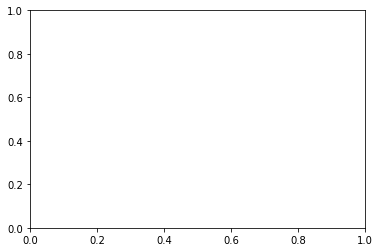

In [12]:
plot_scores({'DDPG': scores})

When finished, we can close the environment.

In [ ]:
env.close()

### Future Work

The tuning of hyperparameters can be further improved.
Possibly a framework like [hyperopt](https://github.com/hyperopt/hyperopt) or [optuna](https://optuna.org) can be used.

Another option for future work would be to use the Multi-Agent DDPG (MADDPG) approach.
It's core idea: during training phase both agent's critics are using information of every single agent whereas the actor selects action only based on each agent's observation. According to [Lowe et al., 2017] this approach should ease training.

Other algorithms for solving the problem might also be interesting, such as:
- PPO
- A3C
- D4PG

Apparently the seeds used in the algorithm might also have a big influence on learning convergence.
It might be very interesting to explore this further.